
# Article Recommendation System

### 1.1 Overview

Every day, a vast number of articles and blog posts are created. With advancements in technology and the proliferation of social media, accessing articles from a multitude of sources has become more convenient. Consequently, information is readily available online, enabling people to educate themselves and develop a deeper understanding of the world.

Platforms such as __Medium__ generate income based on user engagement with their content. When a reader finds a blog post insightful, they are often interested in discovering similar content. However, if readers cannot easily find related articles, they may lose interest and disengage. Therefore, it would be beneficial to provide users with recommendations based on the articles they have read. This can lead to increased readership, with users more likely to read additional articles and possibly subscribe to services for more engaging and valuable content.

### 1.2 Data Source

The dataset used in this project was obtained from __Kaggle__ - a platform that allows users to download extensive datasets for machine learning applications. Below is the link to the website from which the articles and related data were downloaded:

https://www.kaggle.com/datasets/gspmoreira/articles-sharing-reading-from-cit-deskdrop?select=shared_articles.csv

## Table of Contents



In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
import missingno as msno
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('shared_articles.csv')

In [3]:
df.head()

timestamp        eventType            contentId       authorPersonId  \
0  1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1  1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3  1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4  1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
0  8940341205206233829             NaN          NaN           NaN        HTML   
1  8940341205206233829             NaN          NaN           NaN        HTML   
2  8940341205206233829             NaN          NaN           NaN        HTML   
3 -1457532940883382585             NaN          NaN           NaN        HTML   
4  8940341205206233829             NaN          NaN           NaN        HTML   

                                                 url  \
0  http://www.nytimes.com/2016/03/28/business/dea...   
1  http://www.nytimes.com/2016/03/28/business/dea...   
2  http://cointelegraph.com/news/bitcoin-future-w...   
3  https://cloudplatform.googleblog.com/2016/03/G...   
4  https://bitcoinmagazine.com/articles/ibm-wants...   

                                               title  \
0  Ethereum, a Virtual Currency, Enables Transact...   
1  Ethereum, a Virtual Currency, Enables Transact...   
2  Bitcoin Future: When GBPcoin of Branson Wins O...   
3                       Google Data Center 360° Tour   
4  IBM Wants to "Evolve the Internet" With Blockc...   

                                                text lang  
0  All of this work is still very early. The firs...   en  
1  All of this work is still very early. The firs...   en  
2  The alarm clock wakes me at 8:00 with stream o...   en  
3  We're excited to share the Google Data Center ...   en  
4  The Aite Group projects the blockchain market ...   en

In [4]:
df.shape

(3122, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        3122 non-null   int64 
 1   eventType        3122 non-null   object
 2   contentId        3122 non-null   int64 
 3   authorPersonId   3122 non-null   int64 
 4   authorSessionId  3122 non-null   int64 
 5   authorUserAgent  680 non-null    object
 6   authorRegion     680 non-null    object
 7   authorCountry    680 non-null    object
 8   contentType      3122 non-null   object
 9   url              3122 non-null   object
 10  title            3122 non-null   object
 11  text             3122 non-null   object
 12  lang             3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [6]:
df.describe()

timestamp     contentId  authorPersonId  authorSessionId
count  3.122000e+03  3.122000e+03    3.122000e+03     3.122000e+03
mean   1.468804e+09  3.284110e+16    3.984819e+17     1.976675e+17
std    7.571512e+06  5.383734e+18    4.387115e+18     5.403753e+18
min    1.459193e+09 -9.222795e+18   -9.120686e+18    -9.212055e+18
25%    1.462369e+09 -4.660869e+18   -1.578288e+18    -4.651280e+18
50%    1.467136e+09  4.436584e+16   -7.092877e+17     4.154103e+17
75%    1.473873e+09  4.745617e+18    3.609194e+18     4.841644e+18
max    1.488308e+09  9.222265e+18    9.210531e+18     9.221043e+18

<AxesSubplot:>

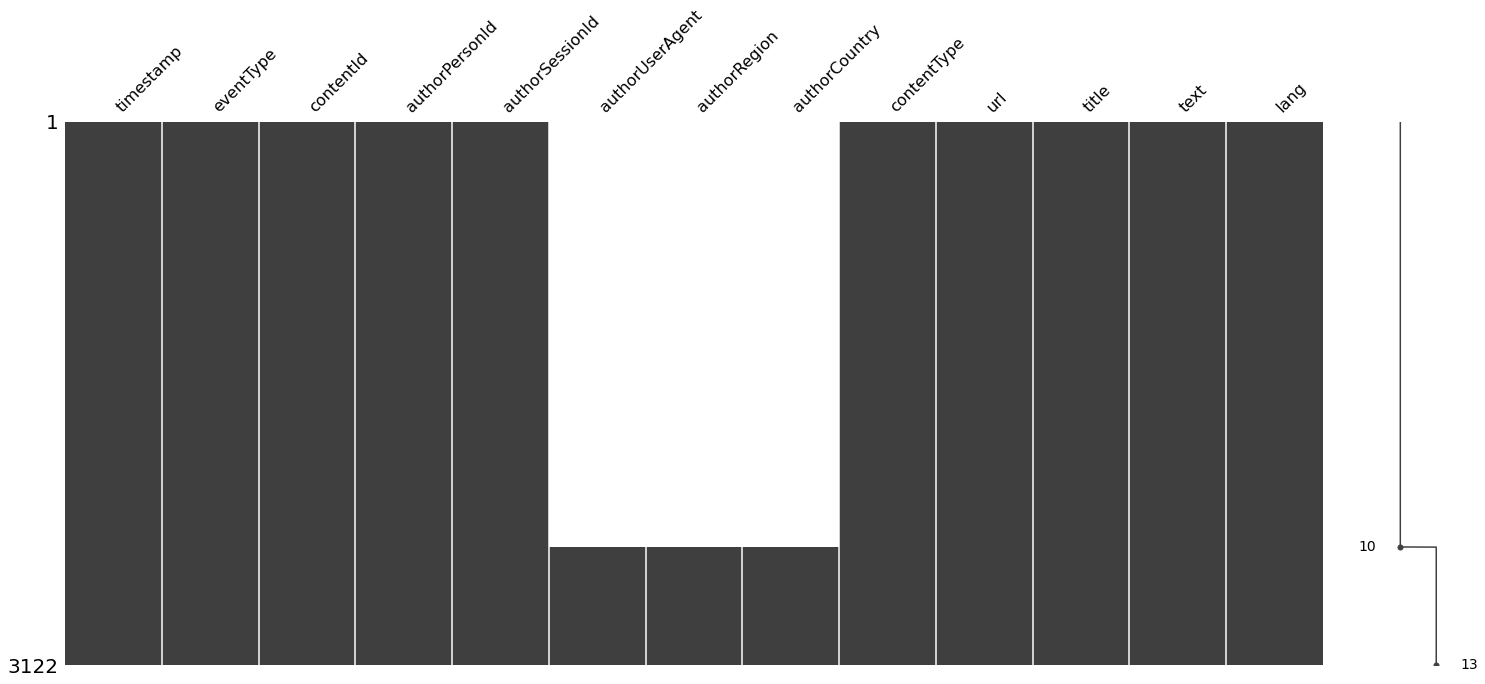

In [7]:
msno.matrix(df)

In [16]:
print("The percentage of english articles in our dataframe: {:.2f}%".format(len(df[df.lang == 'en']) / len(df) * 100))

The percentage of english articles in our dataframe: 72.52%


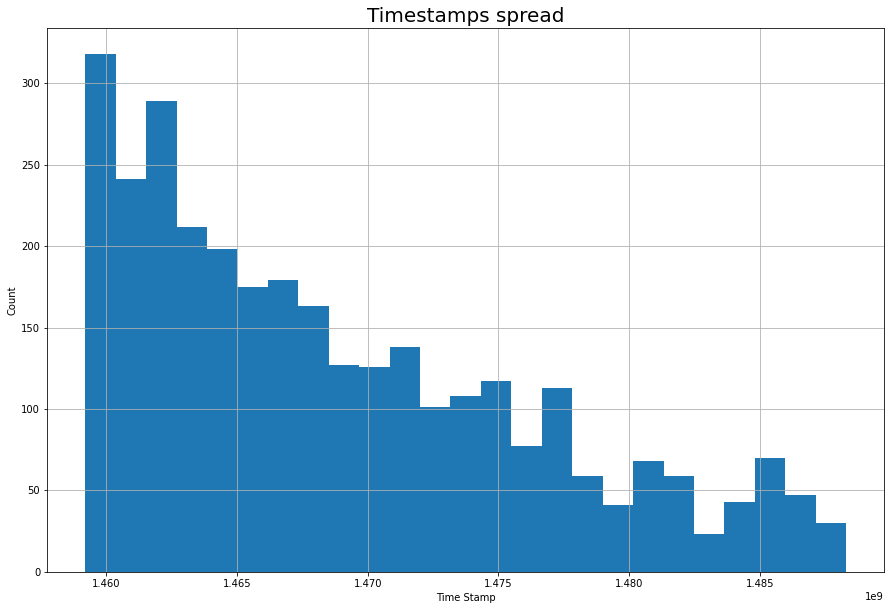

In [630]:
plt.figure(figsize = (15, 10))
df['timestamp'].hist(bins = 25)
plt.title("Timestamps spread", fontsize = 20)
plt.xlabel("Time Stamp")
plt.ylabel("Count")
plt.show()

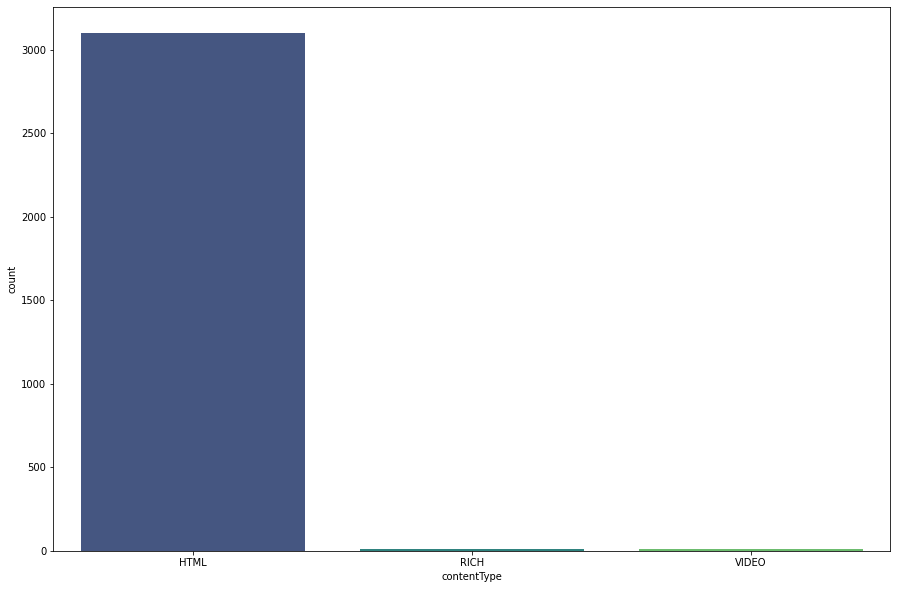

In [631]:
plt.figure(figsize = (15, 10))
sns.countplot(x = 'contentType', data = df, palette = 'viridis')
plt.show()

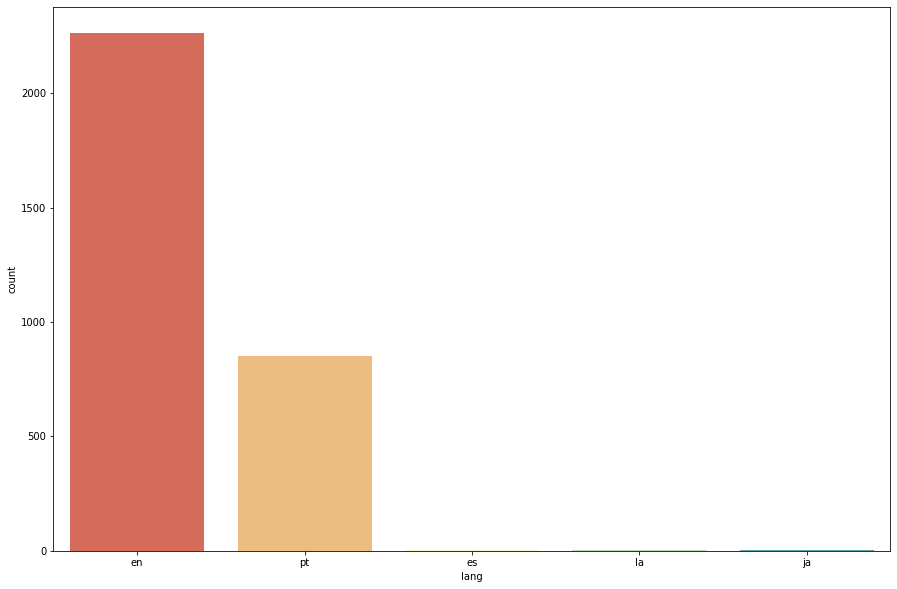

In [632]:
plt.figure(figsize = (15, 10))
sns.countplot(x = 'lang', data = df, palette = 'Spectral')
plt.show()

In [633]:
df = df[df.lang == 'en']

In [634]:
def text_extractor(series):
    text = []
    for i in range(len(series)):
        text.append(series.iloc[i])
    return text

In [635]:
title_text = ' '.join(text_extractor(df['title']))

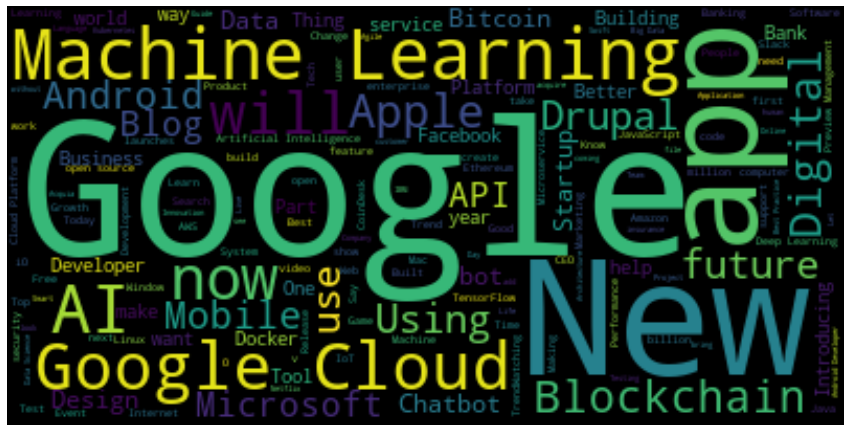

In [636]:
plt.figure(figsize = (15, 10))
wordcloud = WordCloud().generate(title_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [637]:
main_text = ' '.join(text_extractor(df['text']))

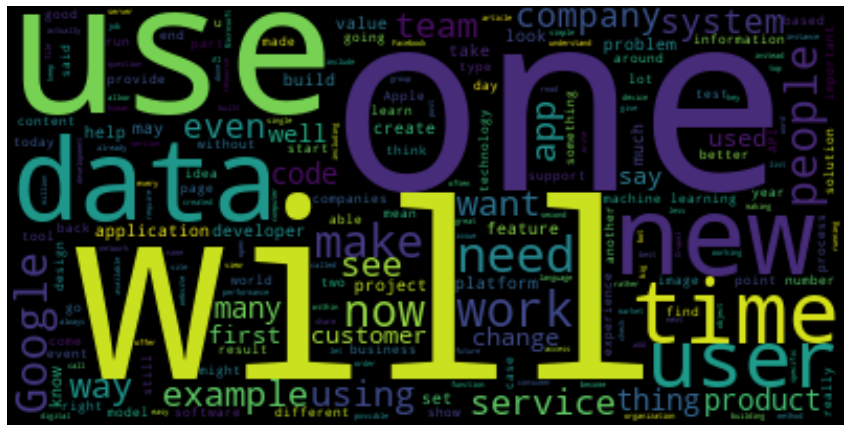

In [638]:
# https://stackoverflow.com/questions/44827346/change-word-color-using-wordcloud-in-python
# Credits to the above website for providing a great detailed explanation of plotting wordcloud with 
# different colors. 
#change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

plt.figure(figsize = (15, 10))
wordcloud = WordCloud().generate(main_text)
plt.imshow(wordcloud, interpolation = 'bilinear')

wordcloud.recolor(color_func = grey_color_func)
plt.axis("off")
plt.show()

In [639]:
# https://stackoverflow.com/a/47091490/4084039


def decontracted(phrase):
    """
    This function would convert some short letters into the forms that one 
    could easily understand respectively.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [640]:
def text_preprocessing(df, feature, stemming = False, lemmatize = True):
    pattern = "[^a-zA-Z0-9]"
    english_stopwords = stopwords.words("english")
    preprocessed_text = []
    for i in tqdm(range(len(df[feature]))):
        text = decontracted(df[feature].iloc[i])
        text = re.sub(pattern, ' ', text)
        text = text.lower()
        text = word_tokenize(text)
        text = [word for word in text if word not in english_stopwords]
        text = [word for word in text if word not in string.punctuation]
        if stemming:
            porter_stemmer = PorterStemmer()
            text = " ".join([porter_stemmer.stem(word) for word in text])
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            text = " ".join([lemmatizer.lemmatize(word) for word in text])
        preprocessed_text.append(text)
    
    return preprocessed_text

In [641]:
preprocessed_text = text_preprocessing(df, feature = "text")

100%|█████████████████████████████████████████████████████████████████████████████| 2264/2264 [00:15<00:00, 147.63it/s]


In [642]:
preprocessed_title = text_preprocessing(df, feature = "title")

100%|████████████████████████████████████████████████████████████████████████████| 2264/2264 [00:00<00:00, 6448.54it/s]


In [643]:
df_main = df[df['lang'] == 'en']

## Principal Component Analysis

In [644]:
vectorizer_text = TfidfVectorizer(stop_words = 'english')
vectorizer_title = TfidfVectorizer(stop_words = 'english')

In [645]:
tfidf_vectorizer_text = vectorizer_text.fit_transform(preprocessed_text)
tfidf_vectorizer_title = vectorizer_title.fit_transform(preprocessed_title)

In [646]:
from sklearn.preprocessing import StandardScaler

In [647]:
scaler = StandardScaler()
tfidf_array = scaler.fit_transform(tfidf_vectorizer_title.toarray())
tfidf_text_array = scaler.fit_transform(tfidf_vectorizer_text.toarray())

In [648]:
from sklearn.decomposition import PCA

In [649]:
print("The size of the tfidf title array is: {}".format(tfidf_array.shape))
print("The size of the tfidf text array is: {}".format(tfidf_text_array.shape))

The size of the tfidf title array is: (2264, 4132)
The size of the tfidf text array is: (2264, 40459)


## PCA for Tfidf Title array

In [650]:
number_of_components = 2000
pca_model = PCA(n_components = number_of_components)
pca_model.fit(tfidf_array)    

PCA(n_components=2000)

In [651]:
total_components = list(range(1, number_of_components + 1))

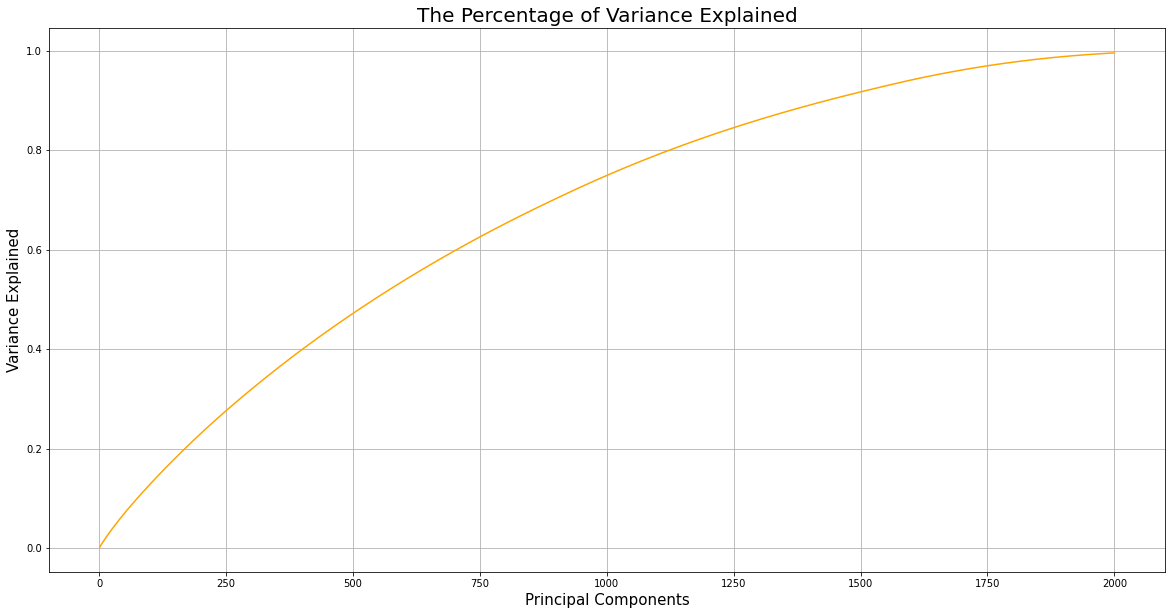

In [652]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = total_components, y = np.cumsum(pca_model.explained_variance_ratio_), color = 'orange')
plt.xlabel('Principal Components', fontsize = 15)
plt.ylabel('Variance Explained', fontsize = 15)
plt.title("The Percentage of Variance Explained", fontsize = 20)
plt.grid(True)
#plt.savefig('Plots/Percentage of Variance Explained.png')
plt.show()

In [653]:
ideal_principal_components = 1500

In [654]:
pca_model = PCA(n_components = ideal_principal_components)
tfidf_title_reduced = pca_model.fit_transform(tfidf_array)

In [655]:
tfidf_title_reduced.shape

(2264, 1500)

In [656]:
print("The initial dimensions of the vectorized_text: {}".format(tfidf_vectorizer_title.shape))

The initial dimensions of the vectorized_text: (2264, 4132)


In [657]:
print("The final dimensions of the vectorized text: {}".format(tfidf_title_reduced.shape))

The final dimensions of the vectorized text: (2264, 1500)


## PCA for Tfidf Text Array

In [658]:
number_of_components = 2000
pca_model = PCA(n_components = number_of_components)
pca_model.fit(tfidf_text_array)    

PCA(n_components=2000)

In [659]:
total_components = list(range(1, number_of_components + 1))

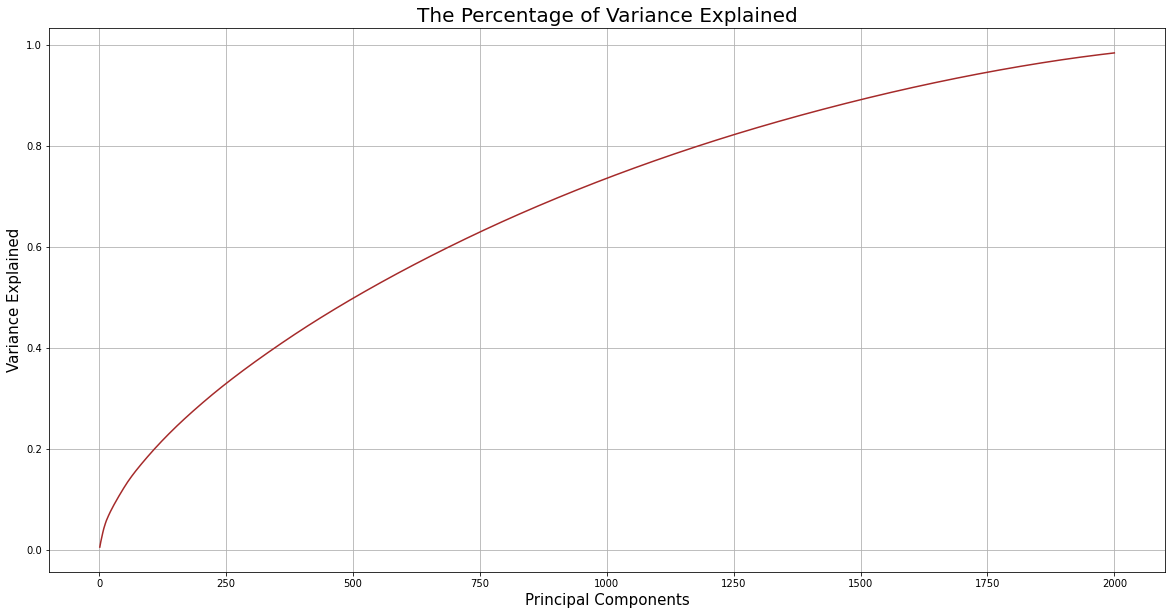

In [660]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = total_components, y = np.cumsum(pca_model.explained_variance_ratio_), color = 'brown')
plt.xlabel('Principal Components', fontsize = 15)
plt.ylabel('Variance Explained', fontsize = 15)
plt.title("The Percentage of Variance Explained", fontsize = 20)
plt.grid(True)
#plt.savefig('Plots/Percentage of Variance Explained.png')
plt.show()

In [661]:
ideal_principal_components = 1750

In [662]:
pca_model = PCA(n_components = ideal_principal_components)
tfidf_text_reduced = pca_model.fit_transform(tfidf_text_array)

In [663]:
print("The initial dimensions of the vectorized_text: {}".format(tfidf_vectorizer_text.shape))

The initial dimensions of the vectorized_text: (2264, 40459)


In [664]:
print("The final dimensions of the vectorized text: {}".format(tfidf_text_reduced.shape))

The final dimensions of the vectorized text: (2264, 1750)


In [665]:
tfidf_title_reduced.shape

(2264, 1500)

In [666]:
tfidf_text_reduced.shape

(2264, 1750)

In [667]:
tfidf_total = np.concatenate((tfidf_title_reduced, tfidf_text_reduced), axis = 1)

## K Means Clustering 

In [668]:
from sklearn.cluster import KMeans

In [669]:
# sum of the squared Euclidean distances of each point to its closest centroid
sse = {}

for i in tqdm(range(2,20)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100,random_state=18).fit(tfidf_total)
    sse[i] = kmeans.inertia_

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.34it/s]


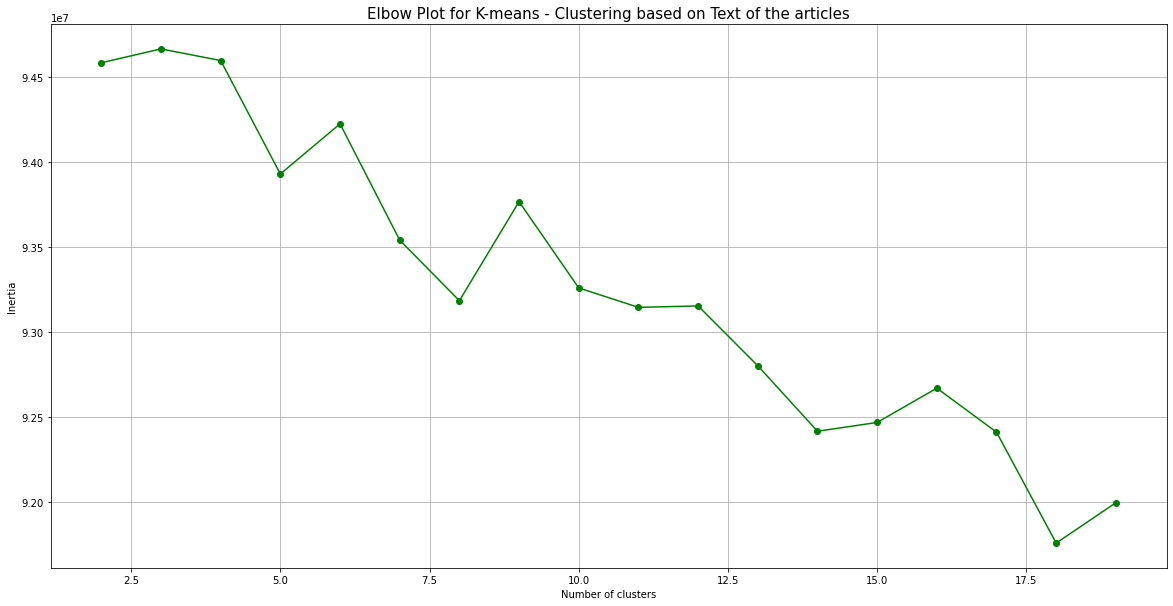

In [670]:
# Plotting the curve with 'k'-value vs distance
plt.figure(figsize=(20,10))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color = 'green')
plt.xlabel("Number of clusters", fontsize = 10)
plt.ylabel("Inertia", fontsize = 10)
plt.title("Elbow Plot for K-means - Clustering based on Text of the articles", fontsize = 15)
plt.grid(True)
plt.show()

In [671]:
best_k = 11

In [672]:
k_model_text = KMeans(n_clusters = best_k, init = 'k-means++', max_iter = 500, n_init = best_k, random_state = 18)

In [673]:
k_model_text.fit(tfidf_total)

KMeans(max_iter=500, n_clusters=11, n_init=11, random_state=18)

In [674]:
df_main["clusters_text"] = k_model_text.labels_

In [675]:
df_main.head()

timestamp        eventType            contentId       authorPersonId  \
0  1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1  1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3  1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4  1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
0  8940341205206233829             NaN          NaN           NaN        HTML   
1  8940341205206233829             NaN          NaN           NaN        HTML   
2  8940341205206233829             NaN          NaN           NaN        HTML   
3 -1457532940883382585             NaN          NaN           NaN        HTML   
4  8940341205206233829             NaN          NaN           NaN        HTML   

                                                 url  \
0  http://www.nytimes.com/2016/03/28/business/dea...   
1  http://www.nytimes.com/2016/03/28/business/dea...   
2  http://cointelegraph.com/news/bitcoin-future-w...   
3  https://cloudplatform.googleblog.com/2016/03/G...   
4  https://bitcoinmagazine.com/articles/ibm-wants...   

                                               title  \
0  Ethereum, a Virtual Currency, Enables Transact...   
1  Ethereum, a Virtual Currency, Enables Transact...   
2  Bitcoin Future: When GBPcoin of Branson Wins O...   
3                       Google Data Center 360° Tour   
4  IBM Wants to "Evolve the Internet" With Blockc...   

                                                text lang  clusters_text  
0  All of this work is still very early. The firs...   en              9  
1  All of this work is still very early. The firs...   en              9  
2  The alarm clock wakes me at 8:00 with stream o...   en              9  
3  We're excited to share the Google Data Center ...   en              9  
4  The Aite Group projects the blockchain market ...   en              9

## Two-Dimensional Visualization Using PCA

Next, let's examine the effectiveness of the PCA model in transforming a high-dimensional vector into a two-dimensional representation. Additionally, we can apply k-means clustering with the optimal value of __k__ identified earlier to determine the ideal number of clusters. For our purposes, __k = 11__ is an effective choice for categorizing the text documents.

The code used here was adapted from the following website:

__Reference__: https://www.askpython.com/python/examples/plot-k-means-clusters-python

In [676]:
tfidf_vectorizer_text

<2264x40459 sparse matrix of type '<class 'numpy.float64'>'
	with 609380 stored elements in Compressed Sparse Row format>

In [677]:
tfidf_vectorizer_title

<2264x4132 sparse matrix of type '<class 'numpy.float64'>'
	with 13390 stored elements in Compressed Sparse Row format>

In [678]:
pca = PCA(n_components = 2)
two_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
two_dim_representation.shape

(2264, 2)

In [679]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(two_dim_representation)

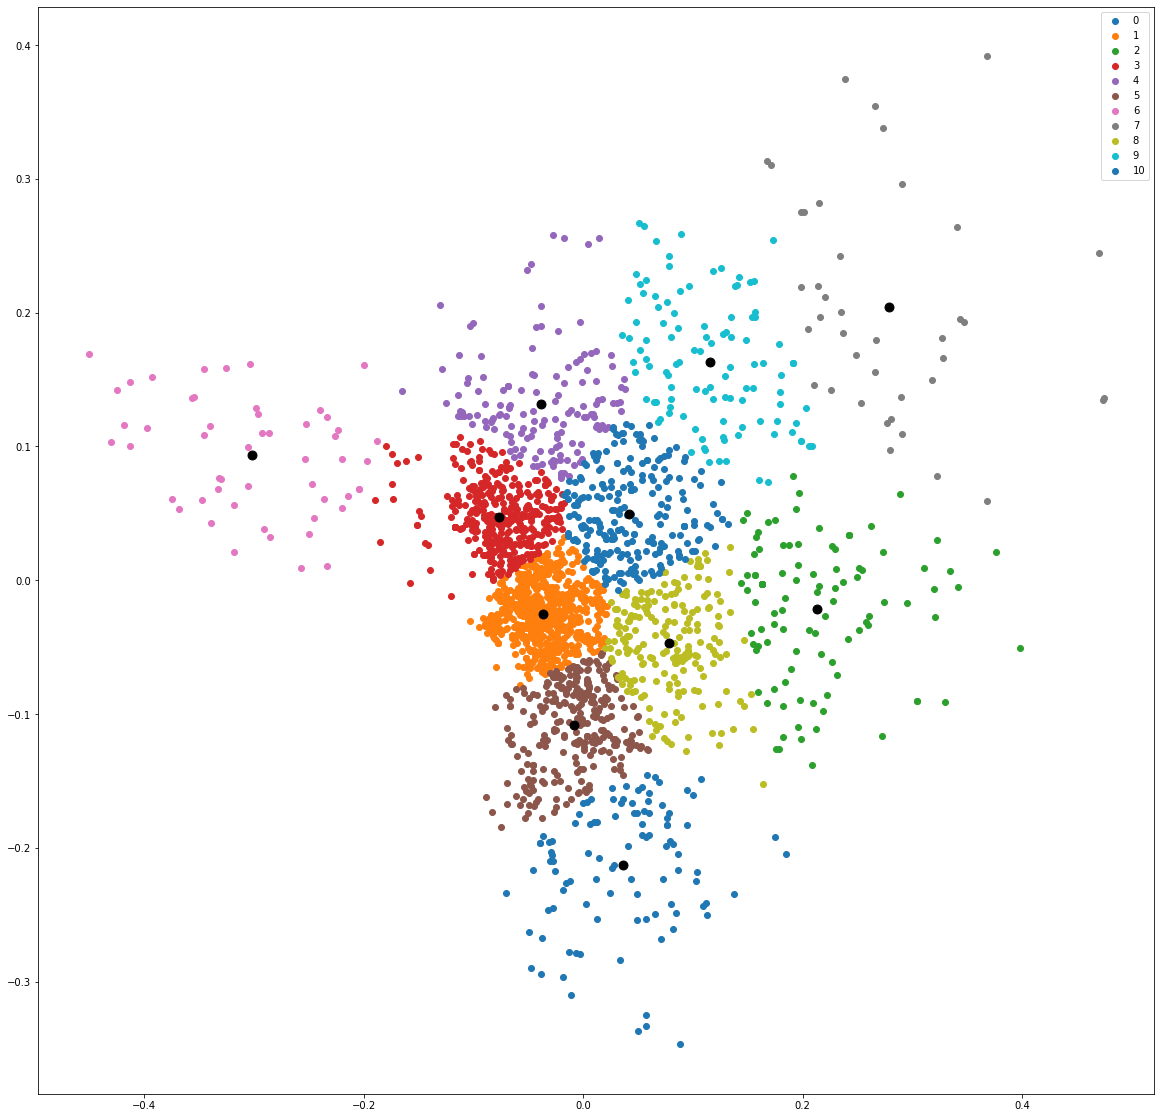

In [680]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize = (20, 20)) 
for i in u_labels:
    plt.scatter(two_dim_representation[label == i , 0] , two_dim_representation[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## Three-Dimensional Visualization Using PCA

Visualizing our data in three dimensions can provide additional insights into the performance of our clustering and help identify any unusual patterns or trends in the data.

Thanks to the following website for offering a detailed explanation:

__Reference__: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


In [681]:
dim_reduction_df = pd.DataFrame()

In [682]:
pca = PCA(n_components = 3)
three_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
dim_reduction_df['pca-one'] = three_dim_representation[:, 0]
dim_reduction_df['pca-two'] = three_dim_representation[:, 1]
dim_reduction_df['pca-three'] = three_dim_representation[:, 2]

In [683]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(three_dim_representation)

In [684]:
dim_reduction_df['clusters'] = label

In [685]:
dim_reduction_df.head()

pca-one   pca-two  pca-three  clusters
0 -0.038920 -0.195669  -0.081870         8
1 -0.038920 -0.195669  -0.081870         8
2 -0.033959 -0.055279  -0.004391         3
3  0.154172  0.196207  -0.120335         6
4 -0.028545 -0.204828  -0.070311         8

In [686]:
dim_reduction_df['pca-one']

0      -0.038920
1      -0.038920
2      -0.033959
3       0.154172
4      -0.028545
          ...   
2259   -0.018794
2260   -0.010037
2261   -0.002697
2262    0.107991
2263   -0.063979
Name: pca-one, Length: 2264, dtype: float64

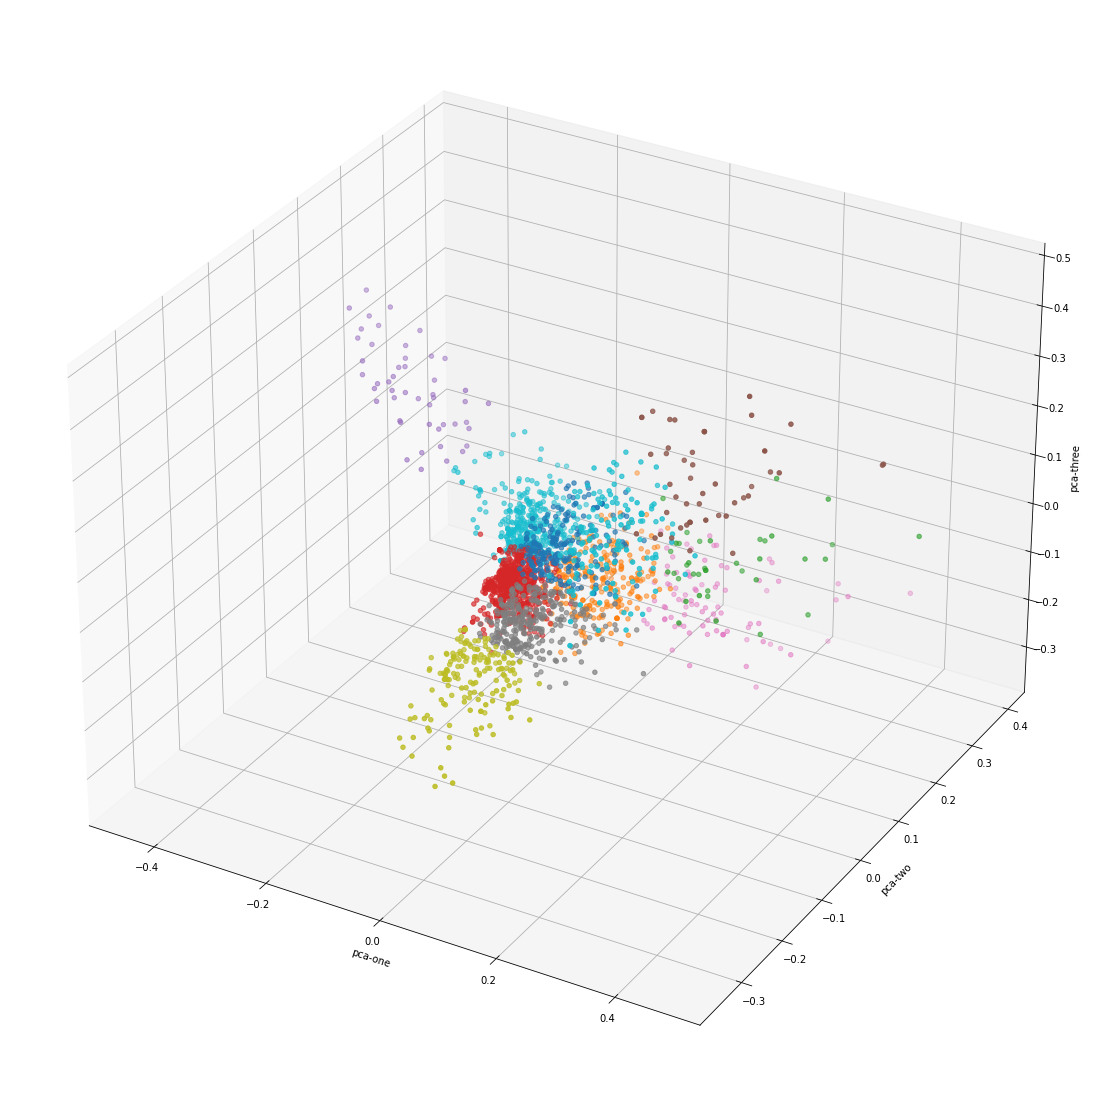

In [687]:
ax = plt.figure(figsize=(20,20)).gca(projection='3d')
ax.scatter(
    xs=dim_reduction_df["pca-one"], 
    ys=dim_reduction_df["pca-two"], 
    zs=dim_reduction_df["pca-three"], 
    c=dim_reduction_df["clusters"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


## Two-Dimensional Visualization Using TSNE

Just as we reduced the dimensions to two using PCA, we will apply a similar procedure with TSNE to observe how clustering is performed and to visualize the data in two dimensions. TSNE (t-Distributed Stochastic Neighbor Embedding) is particularly effective for high-dimensional data and can often reveal patterns that might not be immediately apparent with other dimensionality reduction techniques.

By projecting our data onto a two-dimensional space using TSNE, we aim to gain a better understanding of the inherent structure and clustering behavior of the dataset. This visualization will help us assess the quality of our clustering and identify any underlying trends or anomalies that may not be visible in higher-dimensional representations.

We will compare the results of the TSNE visualization with our PCA results to see if similar clusters emerge, providing further validation of our clustering approach.

The implementation of TSNE in this context is crucial for interpreting complex datasets and ensuring that our machine learning model is capturing meaningful patterns.



In [688]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [689]:
tsne = TSNE(n_components = 2, perplexity = 40, n_iter = 300)
two_dim_representation = tsne.fit_transform(tfidf_vectorizer_text.toarray())
two_dim_representation.shape

(2264, 2)

In [690]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(two_dim_representation)

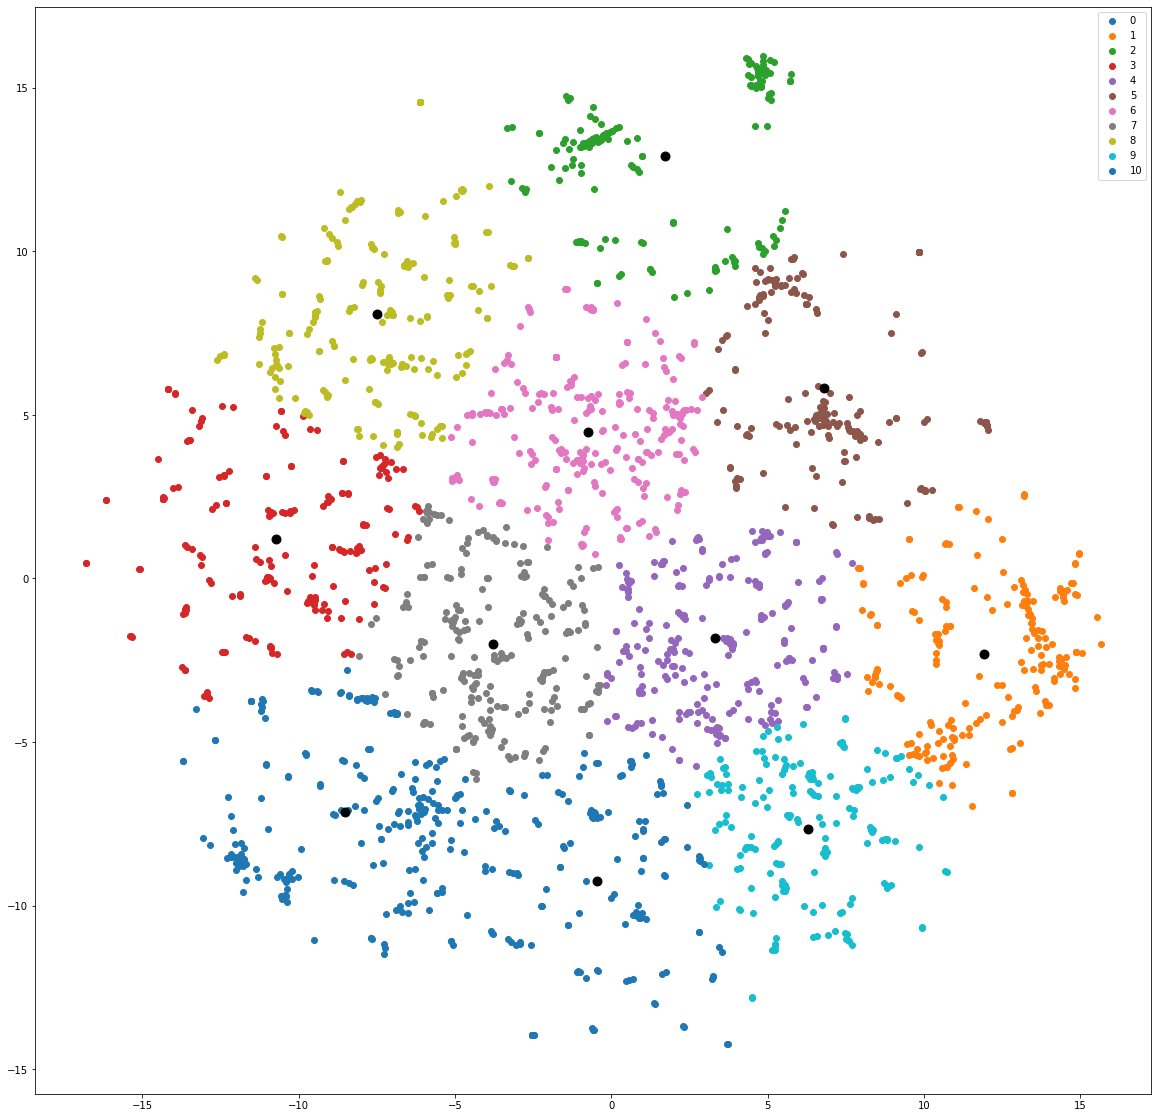

In [691]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize = (20, 20)) 
for i in u_labels:
    plt.scatter(two_dim_representation[label == i , 0] , two_dim_representation[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## Three Dimensional Representation using TSNE

In [692]:
dim_reduction_df = pd.DataFrame()

In [693]:
tsne = TSNE(n_components = 3, perplexity = 40, n_iter = 300)
three_dim_representation = tsne.fit_transform(tfidf_vectorizer_text.toarray())
dim_reduction_df['tsne-one'] = three_dim_representation[:, 0]
dim_reduction_df['tsne-two'] = three_dim_representation[:, 1]
dim_reduction_df['tsne-three'] = three_dim_representation[:, 2]

In [694]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(three_dim_representation)

In [695]:
dim_reduction_df['clusters'] = label

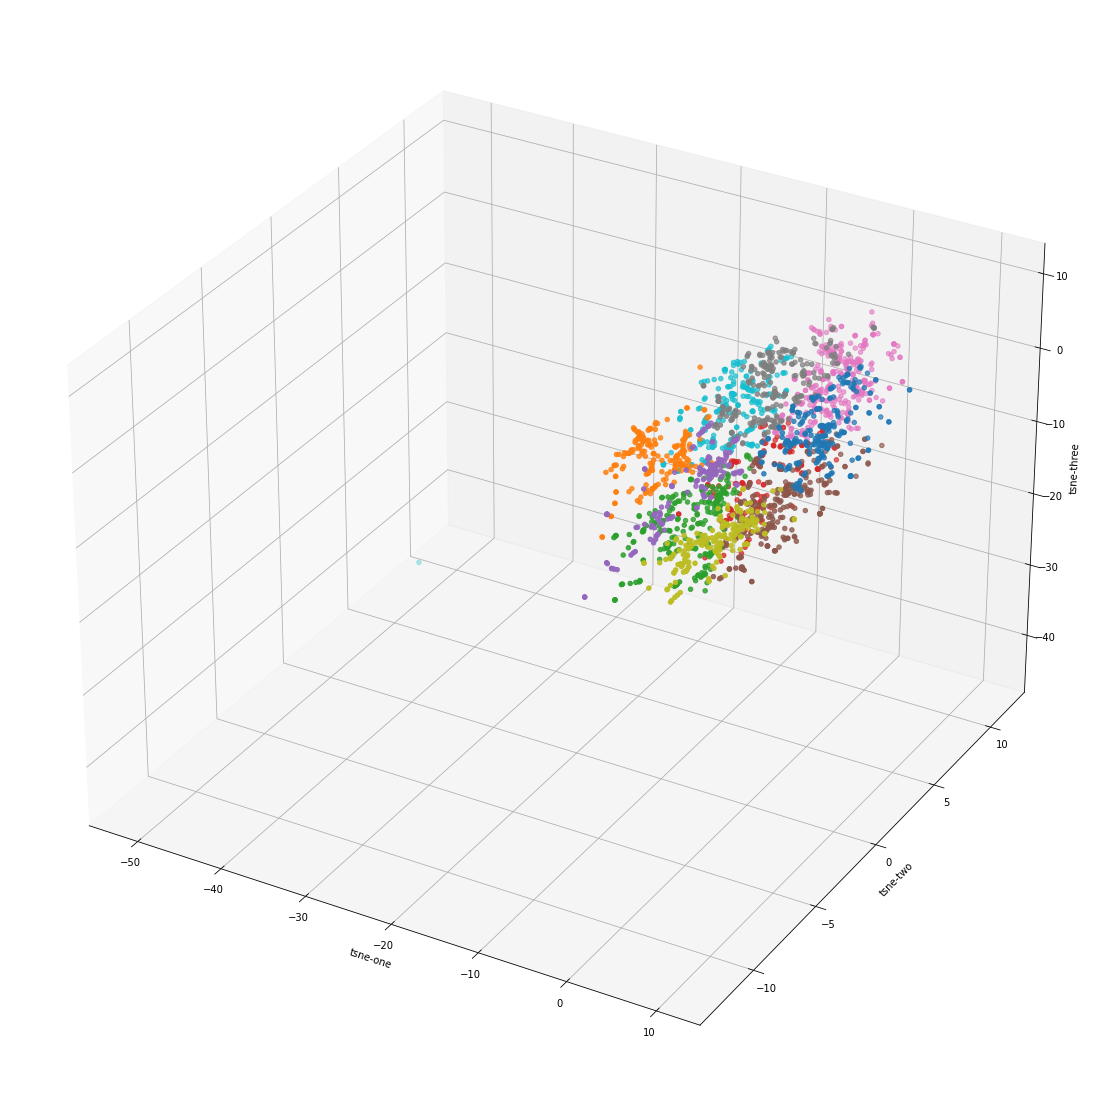

In [696]:
ax = plt.figure(figsize=(20,20)).gca(projection='3d')
ax.scatter(
    xs=dim_reduction_df["tsne-one"], 
    ys=dim_reduction_df["tsne-two"], 
    zs=dim_reduction_df["tsne-three"], 
    c=dim_reduction_df["clusters"], 
    cmap='tab10'
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.show()

## Two Dimensional Representation using Kernel PCA

In [697]:
from sklearn.decomposition import KernelPCA

In [698]:
pca = KernelPCA(n_components = 2, kernel = 'rbf')
two_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
two_dim_representation.shape

(2264, 2)

In [699]:
kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(two_dim_representation)

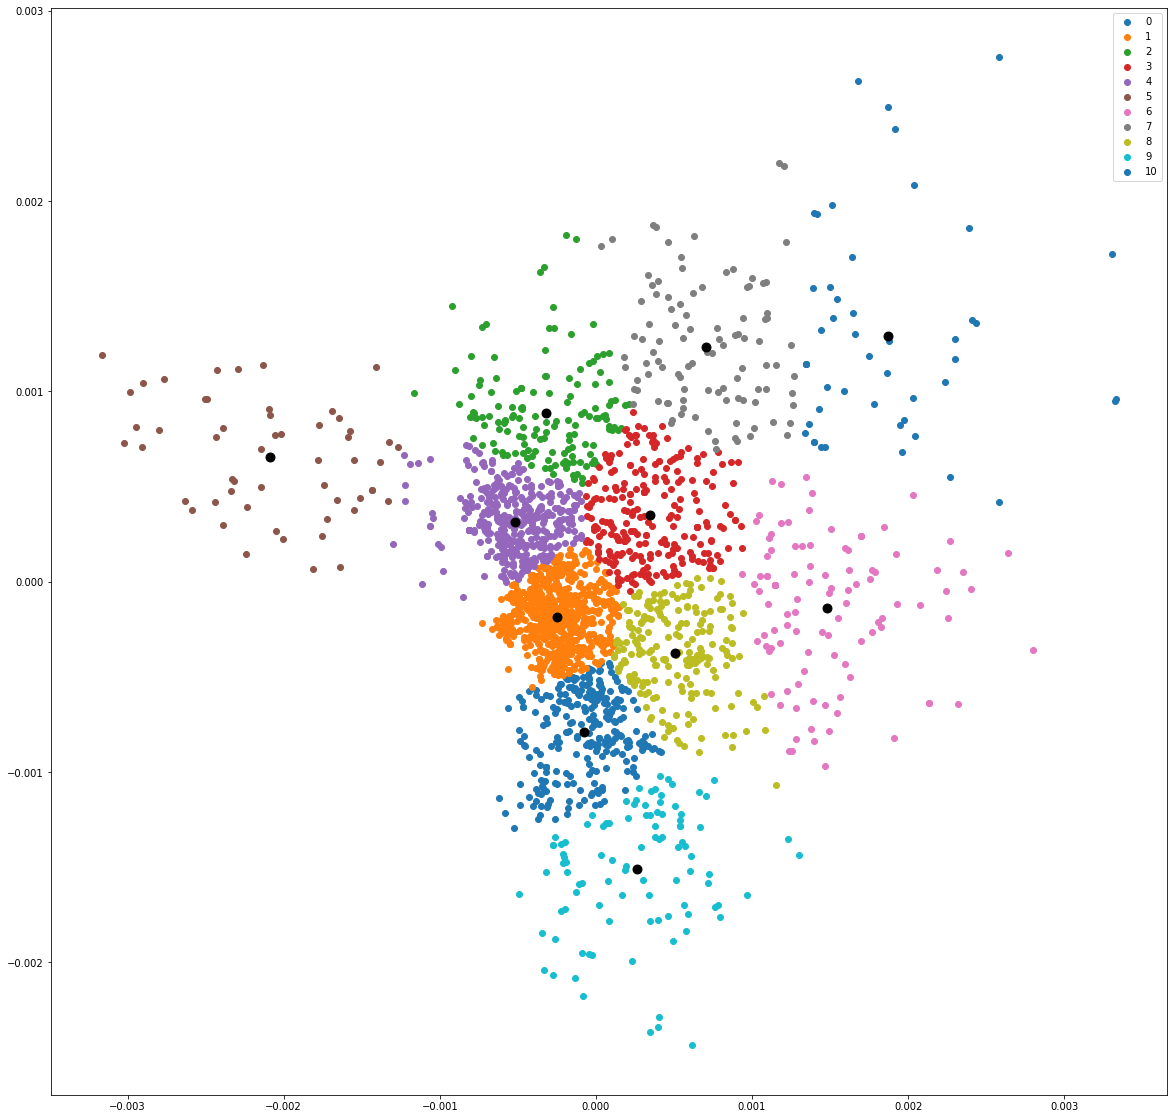

In [700]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize = (20, 20)) 
for i in u_labels:
    plt.scatter(two_dim_representation[label == i , 0] , two_dim_representation[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## Three Dimensional Representation using Kernel PCA

In [701]:
dim_reduction_df = pd.DataFrame()

pca = KernelPCA(n_components = 3, kernel = 'poly')
three_dim_representation = pca.fit_transform(tfidf_vectorizer_text.toarray())
dim_reduction_df['pca-one'] = three_dim_representation[:, 0]
dim_reduction_df['pca-two'] = three_dim_representation[:, 1]
dim_reduction_df['pca-three'] = three_dim_representation[:, 2]

kmeans = KMeans(n_clusters = 11)
label = kmeans.fit_predict(three_dim_representation)

dim_reduction_df['clusters'] = label

dim_reduction_df.head()

pca-one   pca-two  pca-three  clusters
0 -0.000337 -0.001692  -0.000712         7
1 -0.000337 -0.001692  -0.000712         7
2 -0.000296 -0.000478  -0.000050         3
3  0.001327  0.001690  -0.001046         8
4 -0.000247 -0.001769  -0.000612         7

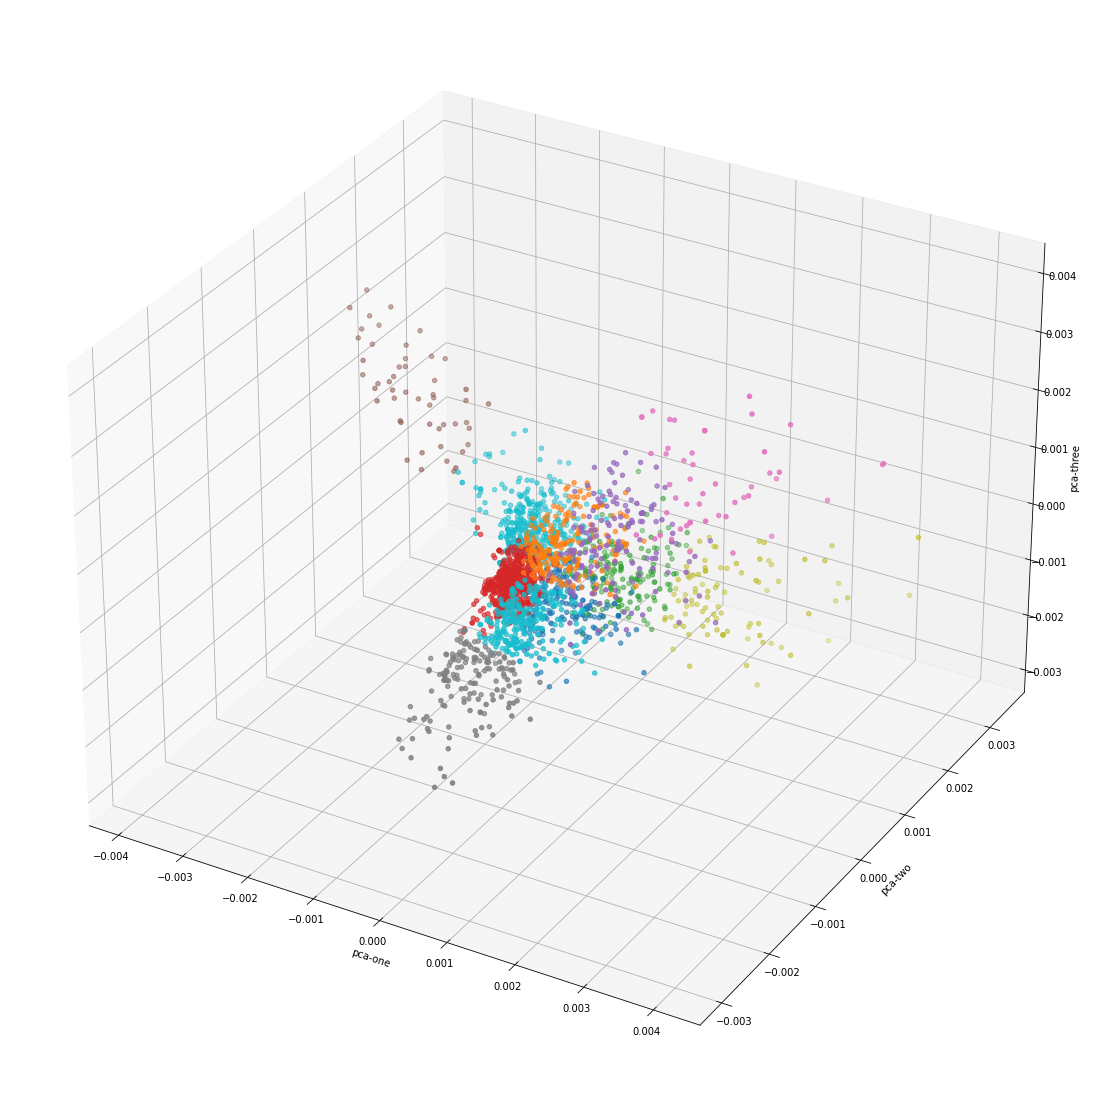

In [702]:
ax = plt.figure(figsize=(20,20)).gca(projection='3d')
ax.scatter(
    xs=dim_reduction_df["pca-one"], 
    ys=dim_reduction_df["pca-two"], 
    zs=dim_reduction_df["pca-three"], 
    c=dim_reduction_df["clusters"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [703]:



def get_useful_features(text_list, stop_words):
    """
    The function would take the dataframe and stopwords and then, convert the excerpts into different features
    such as the number of sentences, words and the length of the lemmas created along with the overall preprocessed
    essay length."""
    sentences = []
    num_of_words = []
    sent_length = []
    word_length = []
    lemma_length = []
    num_of_lemmas = []
    preprocessed_essay_length = []
    initial_text_length = []
    num_of_sentences = []
    text_shortage = []
    
    for text in tqdm(text_list):
        try:
            initial_length = len(text)
            initial_text_length.append(initial_length)
            num_sentences = len(sent_tokenize(text))
            num_of_sentences.append(num_sentences)
            text = re.sub('[^a-zA-Z]', ' ', text)
            text = text.lower()
            text = word_tokenize(text)
            num_words = len(text) 
            num_of_words.append(num_words)
            sent_length.append(num_words/num_sentences)
            word_length.append(initial_length/num_words)
            text = [word for word in text if not word in stop_words]
            lemmatizer = nltk.WordNetLemmatizer()
            text = [lemmatizer.lemmatize(word) for word in text]
            #print(text)
            num_lemmas = len(text)
            num_of_lemmas.append(num_lemmas)
            text = " ".join(text)
            #print(text)
            preprocessed_essay_length_value = len(text)
            preprocessed_essay_length.append(preprocessed_essay_length_value)
            #print(preprocessed_essay_length)
            #print(num_lemmas)
            lemma_length.append(preprocessed_essay_length_value/num_lemmas)
        except:
            continue
        
        text_shortage.append(preprocessed_essay_length_value/initial_length)
        
    final_df = pd.concat([pd.Series(sent_length), pd.Series(num_of_words),
                             pd.Series(word_length), pd.Series(lemma_length),
                             pd.Series(num_of_sentences), pd.Series(initial_text_length),
                             pd.Series(num_of_lemmas), pd.Series(preprocessed_essay_length),
                             pd.Series(text_shortage)], axis = 1)
    final_df.columns = ["sentence_length", "num_of_words", "word_length",
                           "lemma_length", "num_of_sentences",
                           "initial_text_length", "num_of_lemmas",
                           "preprocessed_essay_length", "text_shortage"]
    
    return final_df

In [704]:
import nltk

In [705]:
from nltk.corpus import stopwords

In [706]:
english_stopwords = set(stopwords.words('english'))

In [707]:
features_df_title = get_useful_features(text_list = preprocessed_title, stop_words = english_stopwords)

100%|████████████████████████████████████████████████████████████████████████████| 2264/2264 [00:00<00:00, 8387.88it/s]


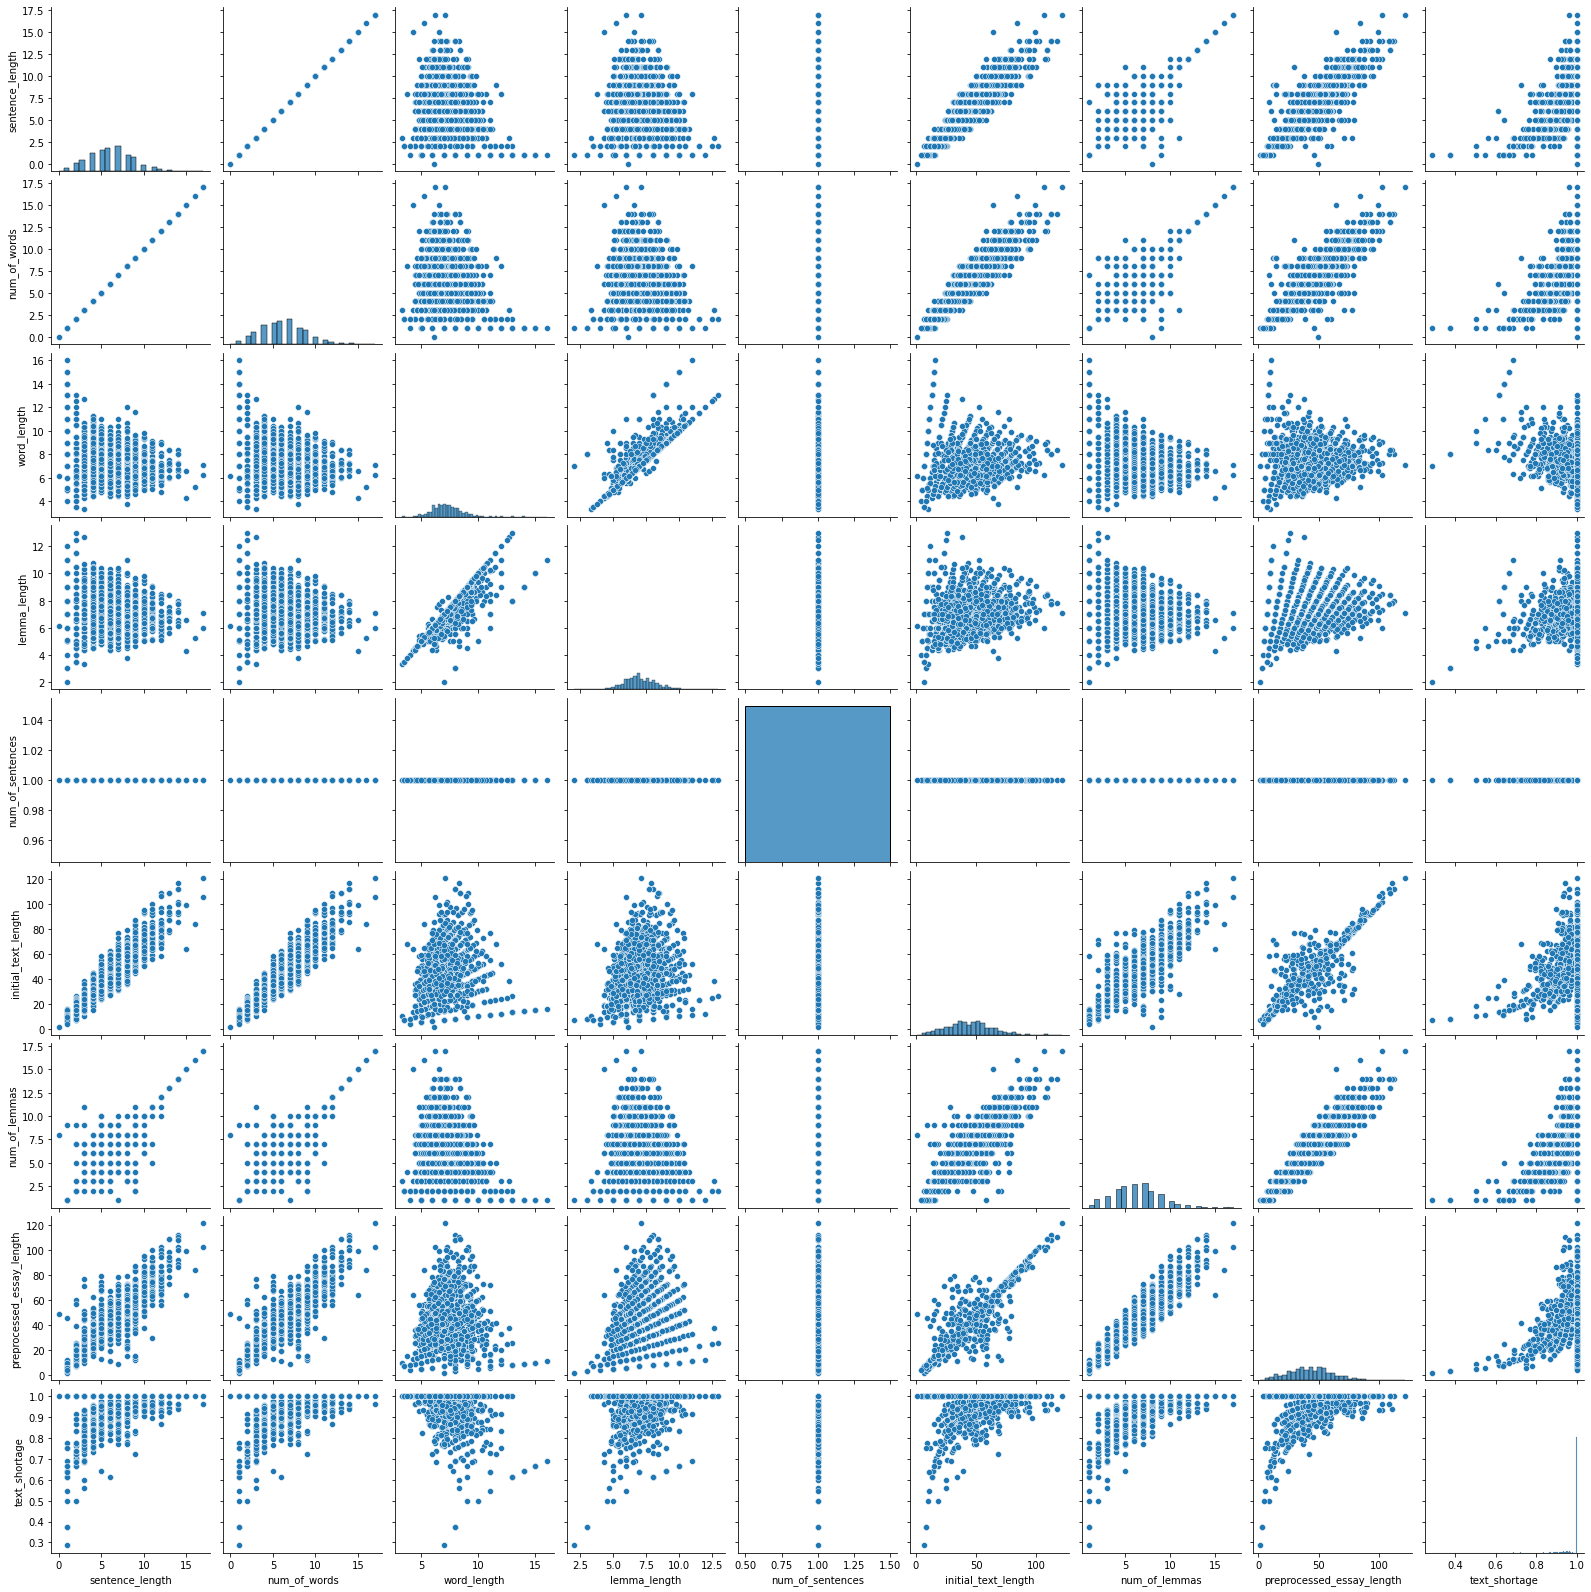

In [708]:
sns.pairplot(data = features_df_title)
plt.show()

In [709]:
features_df_text = get_useful_features(preprocessed_text, stop_words = english_stopwords)

100%|█████████████████████████████████████████████████████████████████████████████| 2264/2264 [00:08<00:00, 282.28it/s]


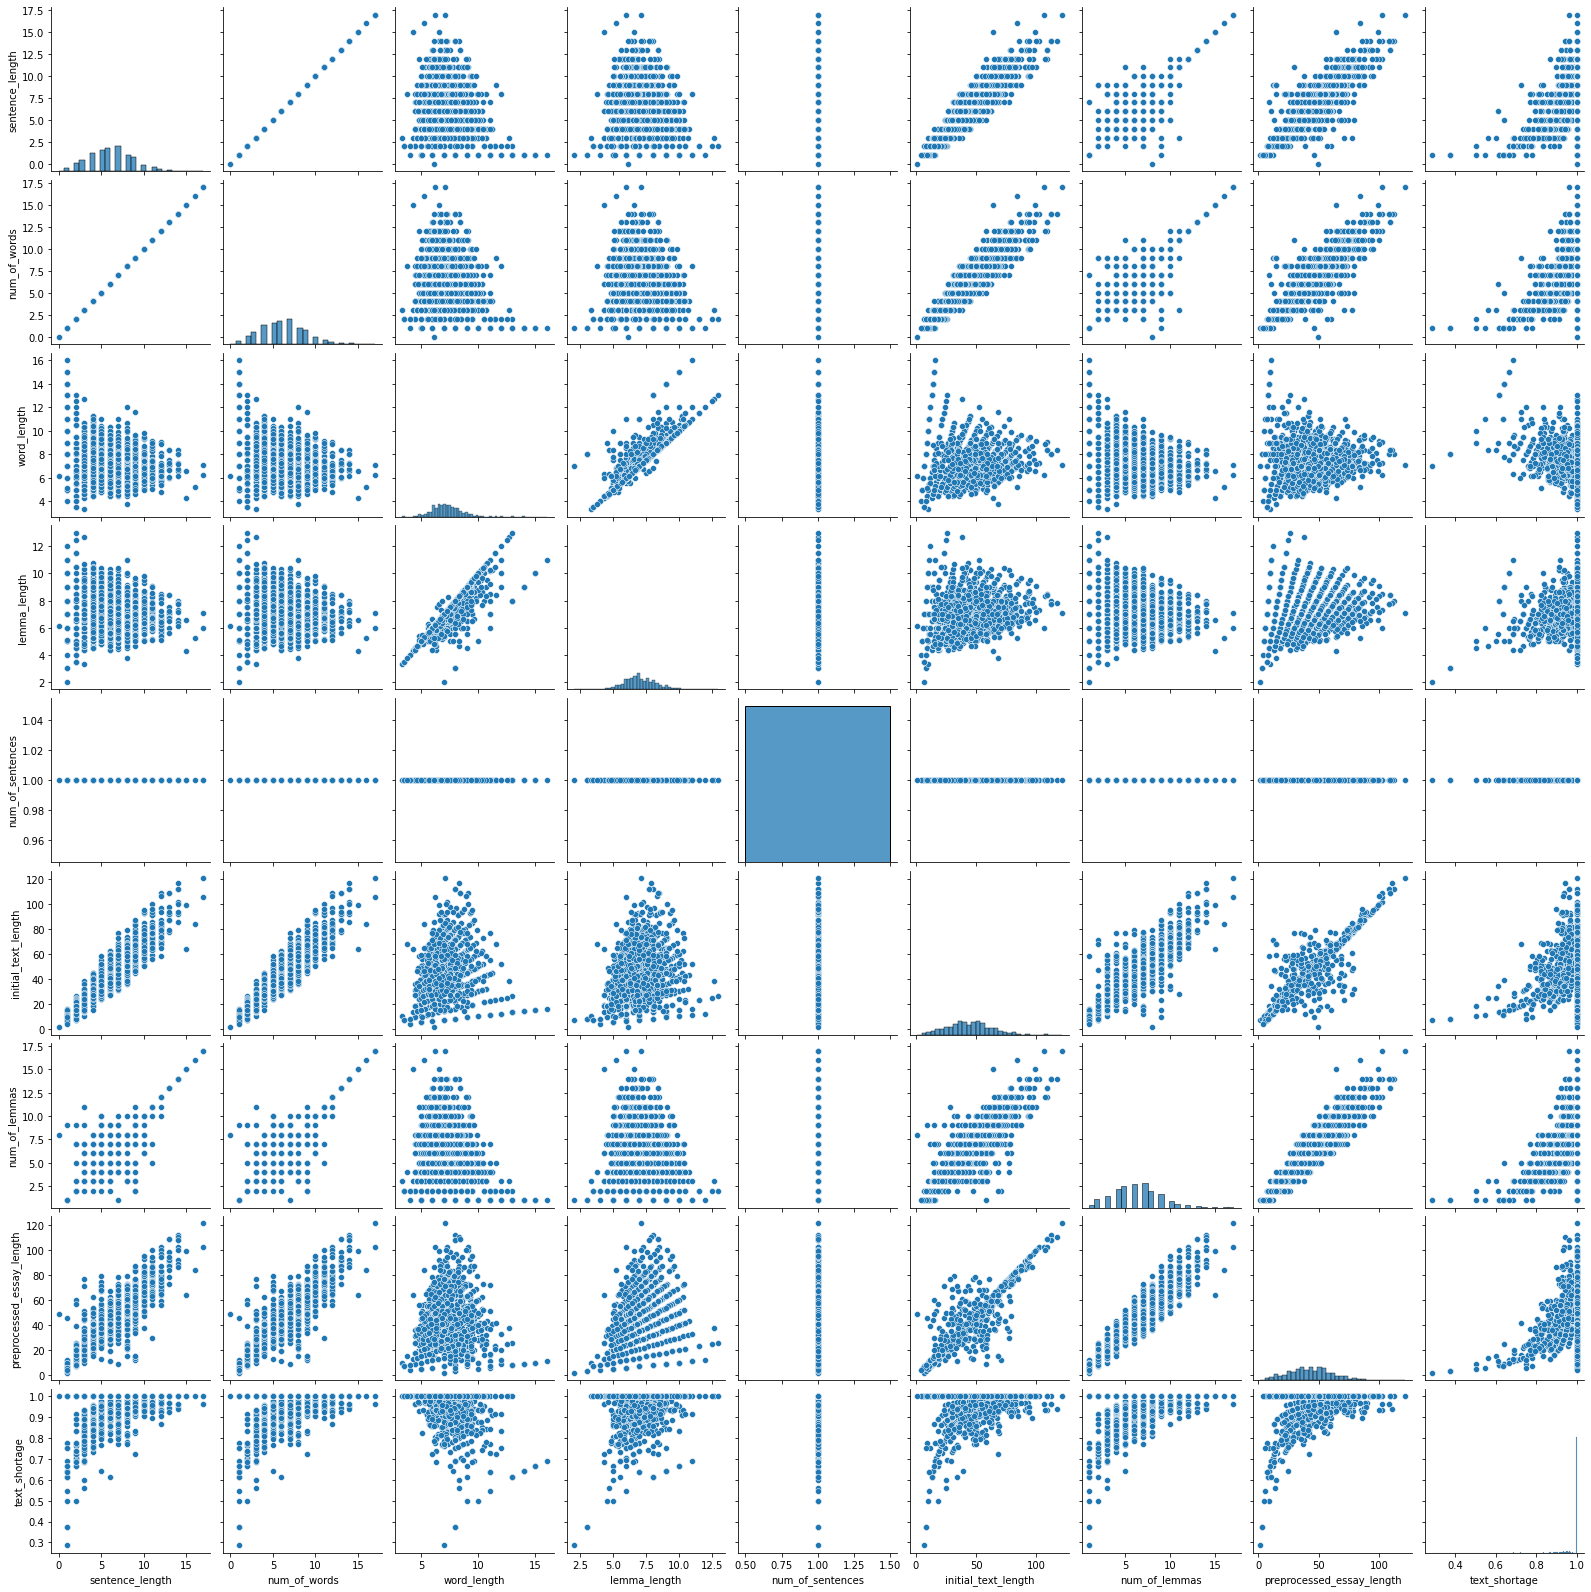

In [710]:
sns.pairplot(data = features_df_title)
plt.show()

In [711]:
features_df_text.head()

sentence_length  num_of_words  word_length  lemma_length  num_of_sentences  \
0            599.0           599     7.592654      7.517529                 1   
1            599.0           599     7.592654      7.517529                 1   
2            203.0           203     7.438424      7.354680                 1   
3            151.0           151     6.841060      6.788079                 1   
4            699.0           699     7.463519      7.391679                 1   

   initial_text_length  num_of_lemmas  preprocessed_essay_length  \
0                 4548            599                       4503   
1                 4548            599                       4503   
2                 1510            203                       1493   
3                 1033            151                       1025   
4                 5217            697                       5152   

   text_shortage  
0       0.990106  
1       0.990106  
2       0.988742  
3       0.992256  
4       0.987541

In [712]:
from sklearn.preprocessing import StandardScaler

In [713]:
scaler = StandardScaler()
features_df_title_standardized = scaler.fit_transform(features_df_title)
features_df_text_standardized = scaler.fit_transform(features_df_text)

In [714]:
features_df_title_standardized.shape

(2264, 9)

In [715]:
features_df_text_standardized.shape

(2264, 9)

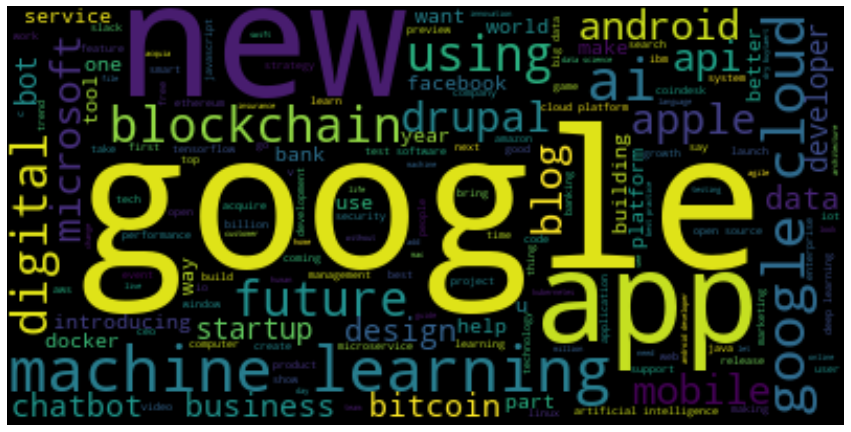

In [716]:
plt.figure(figsize = (15, 10))
wordcloud = WordCloud().generate(" ".join(preprocessed_title))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

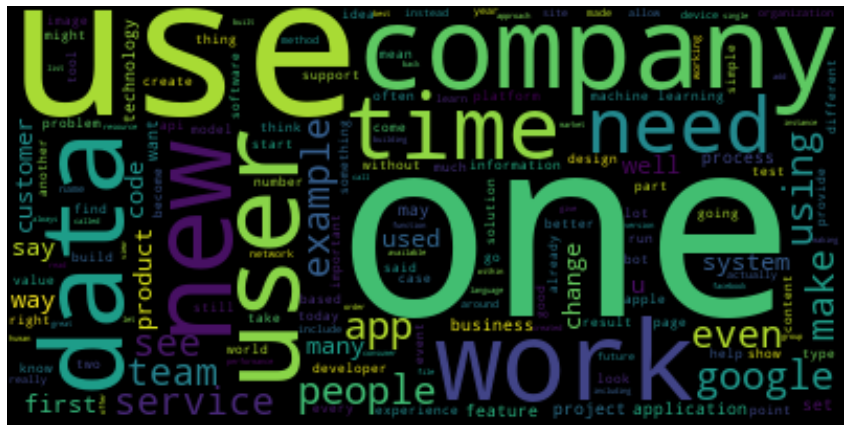

In [717]:
plt.figure(figsize = (15, 10))
wordcloud = WordCloud().generate(" ".join(preprocessed_text))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Content Based Filtering

In [718]:
vectorizer = CountVectorizer()
vectorized_title = vectorizer.fit_transform(preprocessed_title)
vectorized_text = vectorizer.fit_transform(preprocessed_text)

In [719]:
linear_kernel(vectorized_text.toarray()[0: 1], vectorized_text).flatten()

array([2300., 2300.,   69., ...,  934.,  507.,   18.])

In [720]:
similar_document_indices = euclidean_distances(vectorized_text.toarray()[3: 4], vectorized_text).flatten().argsort()[1: 10]

In [721]:
similar_document_indices

array([1504,  719, 1744,  920, 1313, 1008, 1012, 1168, 1678], dtype=int64)

In [722]:
df.iloc[similar_document_indices, :].iloc[: 5]

timestamp       eventType            contentId       authorPersonId  \
2032  1470872079  CONTENT SHARED -8815620240581422908   881856221521045800   
877   1462899171  CONTENT SHARED   279771472506428952 -8845298781299428018   
2374  1474311710  CONTENT SHARED  7756118769128656312  3829784524040647339   
1165  1464721873  CONTENT SHARED -7152753999571084411  3609194402293569455   
1707  1468000605  CONTENT SHARED  9079880752026843473  7527226129639571966   

          authorSessionId authorUserAgent authorRegion authorCountry  \
2032 -6443124096966155946             NaN          NaN           NaN   
877    414537565071856330             NaN          NaN           NaN   
2374  4404062714242930135             NaN          NaN           NaN   
1165  4752652671493723871             NaN          NaN           NaN   
1707  2973078457109900343             NaN          NaN           NaN   

     contentType                                                url  \
2032        HTML  http://www.forbes.com/sites/tomgillis/2016/08/...   
877         HTML  http://www.forbes.com/sites/janakirammsv/2016/...   
2374        HTML  http://simplystatistics.org/2016/09/19/msdr-la...   
1165        HTML  http://trendwatching.com/trends/digital-data-d...   
1707        HTML  https://uxdesign.cc/design-better-forms-96fadc...   

                                                  title  \
2032  Agility in the Cloud: Which "As a Service" Wor...   
877   5 Unique Features Of Google Compute Engine Tha...   
2374  Mastering Software Development in R · Simply S...   
1165  New Asia Trend Briefing from TrendWatching | A...   
1707  Design Better Forms - uxdesign.cc - User Exper...   

                                                   text lang  
2032  The data center is fundamentally changing. Yet...   en  
877   Google Compute Engine (GCE), the infrastructur...   en  
2374  This sequence differs from our previous Data S...   en  
1165  We're living through a data bonanza. Digital i...   en  
1707  Why ask? Omit optional fields and think of oth...   en

In [723]:
df.text.iloc[4]

'The Aite Group projects the blockchain market could be valued at $400 million by 2019. For that reason, some of the biggest names in banking, industry and technology have entered into the space to evaluate how this technology could change the financial world. IBM and Linux, for instance, have brought together some of the brightest minds in the industry and technology to work on blockchain technology through the Hyperledger Project. The Hyperledger Project is under the umbrella of the Linux Foundation, and seeks to incorporate findings by blockchain projects such as Blockstream, Ripple, Digital Asset Holdings and others in order to make blockchain technology useful for the world\'s biggest corporations. IBM has also contributed its own code to the project. According to John Wolpert, IBM\'s Global Blockchain Offering Director, when IBM and Linux began working together on the blockchain project, Linux made clear it wanted to "disrupt the disruption," in part with their findings, as well 

In [724]:
df.iloc[similar_document_indices, :].iloc[3].text

"We're living through a data bonanza. Digital innovators, startup founders, marketers and CEOs can't get enough customer data. And in Asia - the global epicenter of digital consumerism - the data is pouring in! But amid the excitement of the data onslaught - tell me who my customers are! Where they've been! Who they like! What they BUY! - it's easy to miss one simple truth. The best customer data and the most sophisticated tech won't get you anywhere unless you use it to create new products, services, campaigns that your customers love. Consumers are willing to share data and information - with the condition that brands use it to make life better for them. So the big question: how can roll out data-fueled offerings that do just that? Luckily, we have some thoughts ;)"

In [725]:
df.title.iloc[0]

"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"

In [726]:
vectorizer = TfidfVectorizer()
tfidf_vectorized_text = vectorizer.fit_transform(preprocessed_text)
tfidf_vectorized_title = vectorizer.fit_transform(preprocessed_title)

In [727]:
tfidf_vectorized_text

<2264x40660 sparse matrix of type '<class 'numpy.float64'>'
	with 672524 stored elements in Compressed Sparse Row format>

In [728]:
tfidf_vectorized_text.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05741444, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.09864278, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0712892 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [729]:
similar_document_indices = euclidean_distances(tfidf_vectorized_text.toarray()[0: 1], tfidf_vectorized_text).flatten().argsort()[0: 10]

In [730]:
df.loc[similar_document_indices, :].iloc[5].text

"A few weeks ago I had to go through the process of setting up php code sniffer on my new computer, and realised how confusing most of the blog posts out there are and how many loops and posts you have to jump through to get it set up. I decided to write a quick post with all the commands in one place and small descriptions for most of the commands: Installing Drupal Coding Sniffer 1. Download php code sniffer (source code: curl -OL curl -OL sudo mv phpcs.phar /usr/bin/phpcs sudo mv phpcbf.phar /usr/bin/phpcbf sudo chmod a+x /usr/bin/phpc* Test that it's installed by running phpcs -h and it should output the code sniffer help. 2. Download the Coder module Note: download the 8.x branch, even if you intend to use it on Drupal 7. You can download it in any 'normal' folder, but not in a Drupal project. cd /folder/where/i/want/coder drush dl coder It should download the latest version which is 8.x - if it doesn't then add --select to the drush command and choose the 8.x branch. 3. Add Drupa

## Cosine Distances

In [731]:
from scipy.spatial.distance import cosine

In [732]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [733]:
similar_document_indices_cosine = cosine_distances(tfidf_vectorized_text.toarray()[0: 1], tfidf_vectorized_text).flatten().argsort()[0: 10]

In [734]:
top_5_recommendations = []
for i in range(1, 6):
    top_5_recommendations.append(df.loc[similar_document_indices_cosine, :].iloc[i].title)

In [735]:
top_5_recommendations

["Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's",
 'The Rise And Growth of Ethereum Gets Mainstream Coverage',
 'Say Hello to React CDK - KADIRA VOICE',
 'The inside story of how Amazon created Echo, the next billion dollar business no one saw coming',
 'Setting up Drupal Code Sniffer']

In [736]:
#!c:\python38\python.exe -m pip install gensim

In [737]:
user_input = ['The robot cannot see the human arm during the entire dressing process. In particular, it cannot always see the elbow or determine its precise position or bearing. That, in turn, affects the amount of force the robot has to apply to pull the article of clothing — such as a long-sleeve shirt — from the hand to the shoulder.']

In [738]:
user_input

['The robot cannot see the human arm during the entire dressing process. In particular, it cannot always see the elbow or determine its precise position or bearing. That, in turn, affects the amount of force the robot has to apply to pull the article of clothing — such as a long-sleeve shirt — from the hand to the shoulder.']

In [739]:
text_transformed = vectorizer_text.transform(user_input).toarray()

In [740]:
text_transformed[0].reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.]])

## Recommendation System - Clustering Based

In [745]:
def cluster_predict(input_txt,text = True, title = False):
    
    if text:
        clu = vectorizer_text.transform((input_txt))
        pred = k_model_text.predict(clu)
    if title:
        clu = vectorizer_title.transform((input_txt))
        pred = k_model_title.predict(clu)
        
    return pred

In [746]:
def recommend(input_txt,text=True,title=False):

    # Predicting the cluster
    prediction = (cluster_predict(input_txt,text,title))
    
    # Based on the above prediction 10 random articles are recommended from the whole data-frame
    
    if text:
        temp = df_main[df_main['clusters_text'] == prediction[0]]
    if title:
        temp = df_main[df_main['clusters_title'] == prediction[0]]        
        
    temp = temp.sample(5)
    print('Cluster number is: ',prediction[0])
    
    return set(temp['title'])

In [ ]:
# provide user-input title based
user_input = ['Learning to think critically about machine learning'] #change the input
res = recommend(user_input, False, True)

print('Recommending top 5 articles according to the user input based on title:')
res

In [ ]:
# provide user-input title based
user_input = ['Block Chain and Crypto Currency'] #change the input
res = recommend(user_input, False, True)

print('Recommending top 5 articles according to the user input based on title:')
res